In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.ensemble._forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.simplefilter('ignore')

In [2]:
# Setup
network_apps_df_raw = pd.read_csv('data/dataset_application_labelled_146.csv')

In [3]:
network_apps_df_raw.dtypes

flow_key                 object
src_ip_numeric            int64
src_ip                   object
src_port                  int64
dst_ip                   object
dst_port                  int64
proto                     int64
pktTotalCount             int64
octetTotalCount           int64
min_ps                    int64
max_ps                    int64
avg_ps                  float64
std_dev_ps              float64
flowStart               float64
flowEnd                 float64
flowDuration            float64
min_piat                float64
max_piat                float64
avg_piat                float64
std_dev_piat            float64
f_pktTotalCount           int64
f_octetTotalCount         int64
f_min_ps                  int64
f_max_ps                  int64
f_avg_ps                float64
f_std_dev_ps            float64
f_flowStart             float64
f_flowEnd               float64
f_flowDuration          float64
f_min_piat              float64
f_max_piat              float64
f_avg_pi

In [4]:
# Sample rows for less work
net_apps_df = network_apps_df_raw.sample(500000)
net_apps_df.drop(['flow_key', 'src_ip_numeric', 'src_ip', 'dst_ip','category','application_protocol'], axis=1, inplace=True)
net_apps_df_feats = net_apps_df.drop(['web_service'], axis=1)

In [5]:
net_apps_df_feats

,src_port,dst_port,proto,pktTotalCount,octetTotalCount,min_ps,max_ps,avg_ps,std_dev_ps,flowStart,...,b_avg_ps,b_std_dev_ps,b_flowStart,b_flowEnd,b_flowDuration,b_min_piat,b_max_piat,b_avg_piat,b_std_dev_piat,flowEndReason
2176341,52210,53,17,2,212,82,130,106.000000,24.000000,1.559683e+09,...,130.000000,0.000000,1.559683e+09,1.559683e+09,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2
1381496,50027,443,6,12,1434,40,557,119.500000,146.787545,1.556302e+09,...,85.000000,58.041365,1.556302e+09,1.556302e+09,1.554746e+12,0.001260,0.141836,0.053597,0.057470,4
500167,57657,53,17,2,184,66,118,92.000000,26.000000,1.556030e+09,...,118.000000,0.000000,1.556030e+09,1.556030e+09,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2
595114,40152,443,6,1,52,52,52,52.000000,0.000000,1.556047e+09,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2
1073733,32461,53,17,2,182,70,112,91.000000,21.000000,1.556125e+09,...,112.000000,0.000000,1.556125e+09,1.556125e+09,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64887,60710,53,17,2,173,62,111,86.500000,24.500000,1.555975e+09,...,111.000000,0.000000,1.555975e+09,1.555975e+09,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2
177753,52003,443,6,2,92,40,52,46.000000,6.000000,1.555969e+09,...,40.000000,0.000000,1.555969e+09,1.555969e+09,0.000000e+00,0.000000,0.000000,0.000000,0.000000,4
1267899,49498,3128,6,28,1276,40,52,45.571429,5.576920,1.556308e+09,...,50.285714,4.199125,1.556308e+09,1.556308e+09,1.554752e+12,0.001538,45.004227,41.513016,11.983674,3
749951,57324,19302,17,7,372,48,60,53.142857,5.938460,1.556138e+09,...,60.000000,0.000000,1.556138e+09,1.556138e+09,1.554582e+12,10.073221,10.080511,10.076866,0.003645,2


In [6]:
# Under sample
X_train,X_test,y_train,y_test = train_test_split(net_apps_df.drop(['web_service'], axis=1), net_apps_df['web_service'],test_size=0.3)

web_service
Google       210970
DNS          155053
TLS           95949
Unknown       92278
Microsoft     63583
              ...  
Zoom              1
MySQL             1
GTP               1
H323              1
RTSP              1
Name: count, Length: 132, dtype: int64


<Axes: ylabel='web_service'>

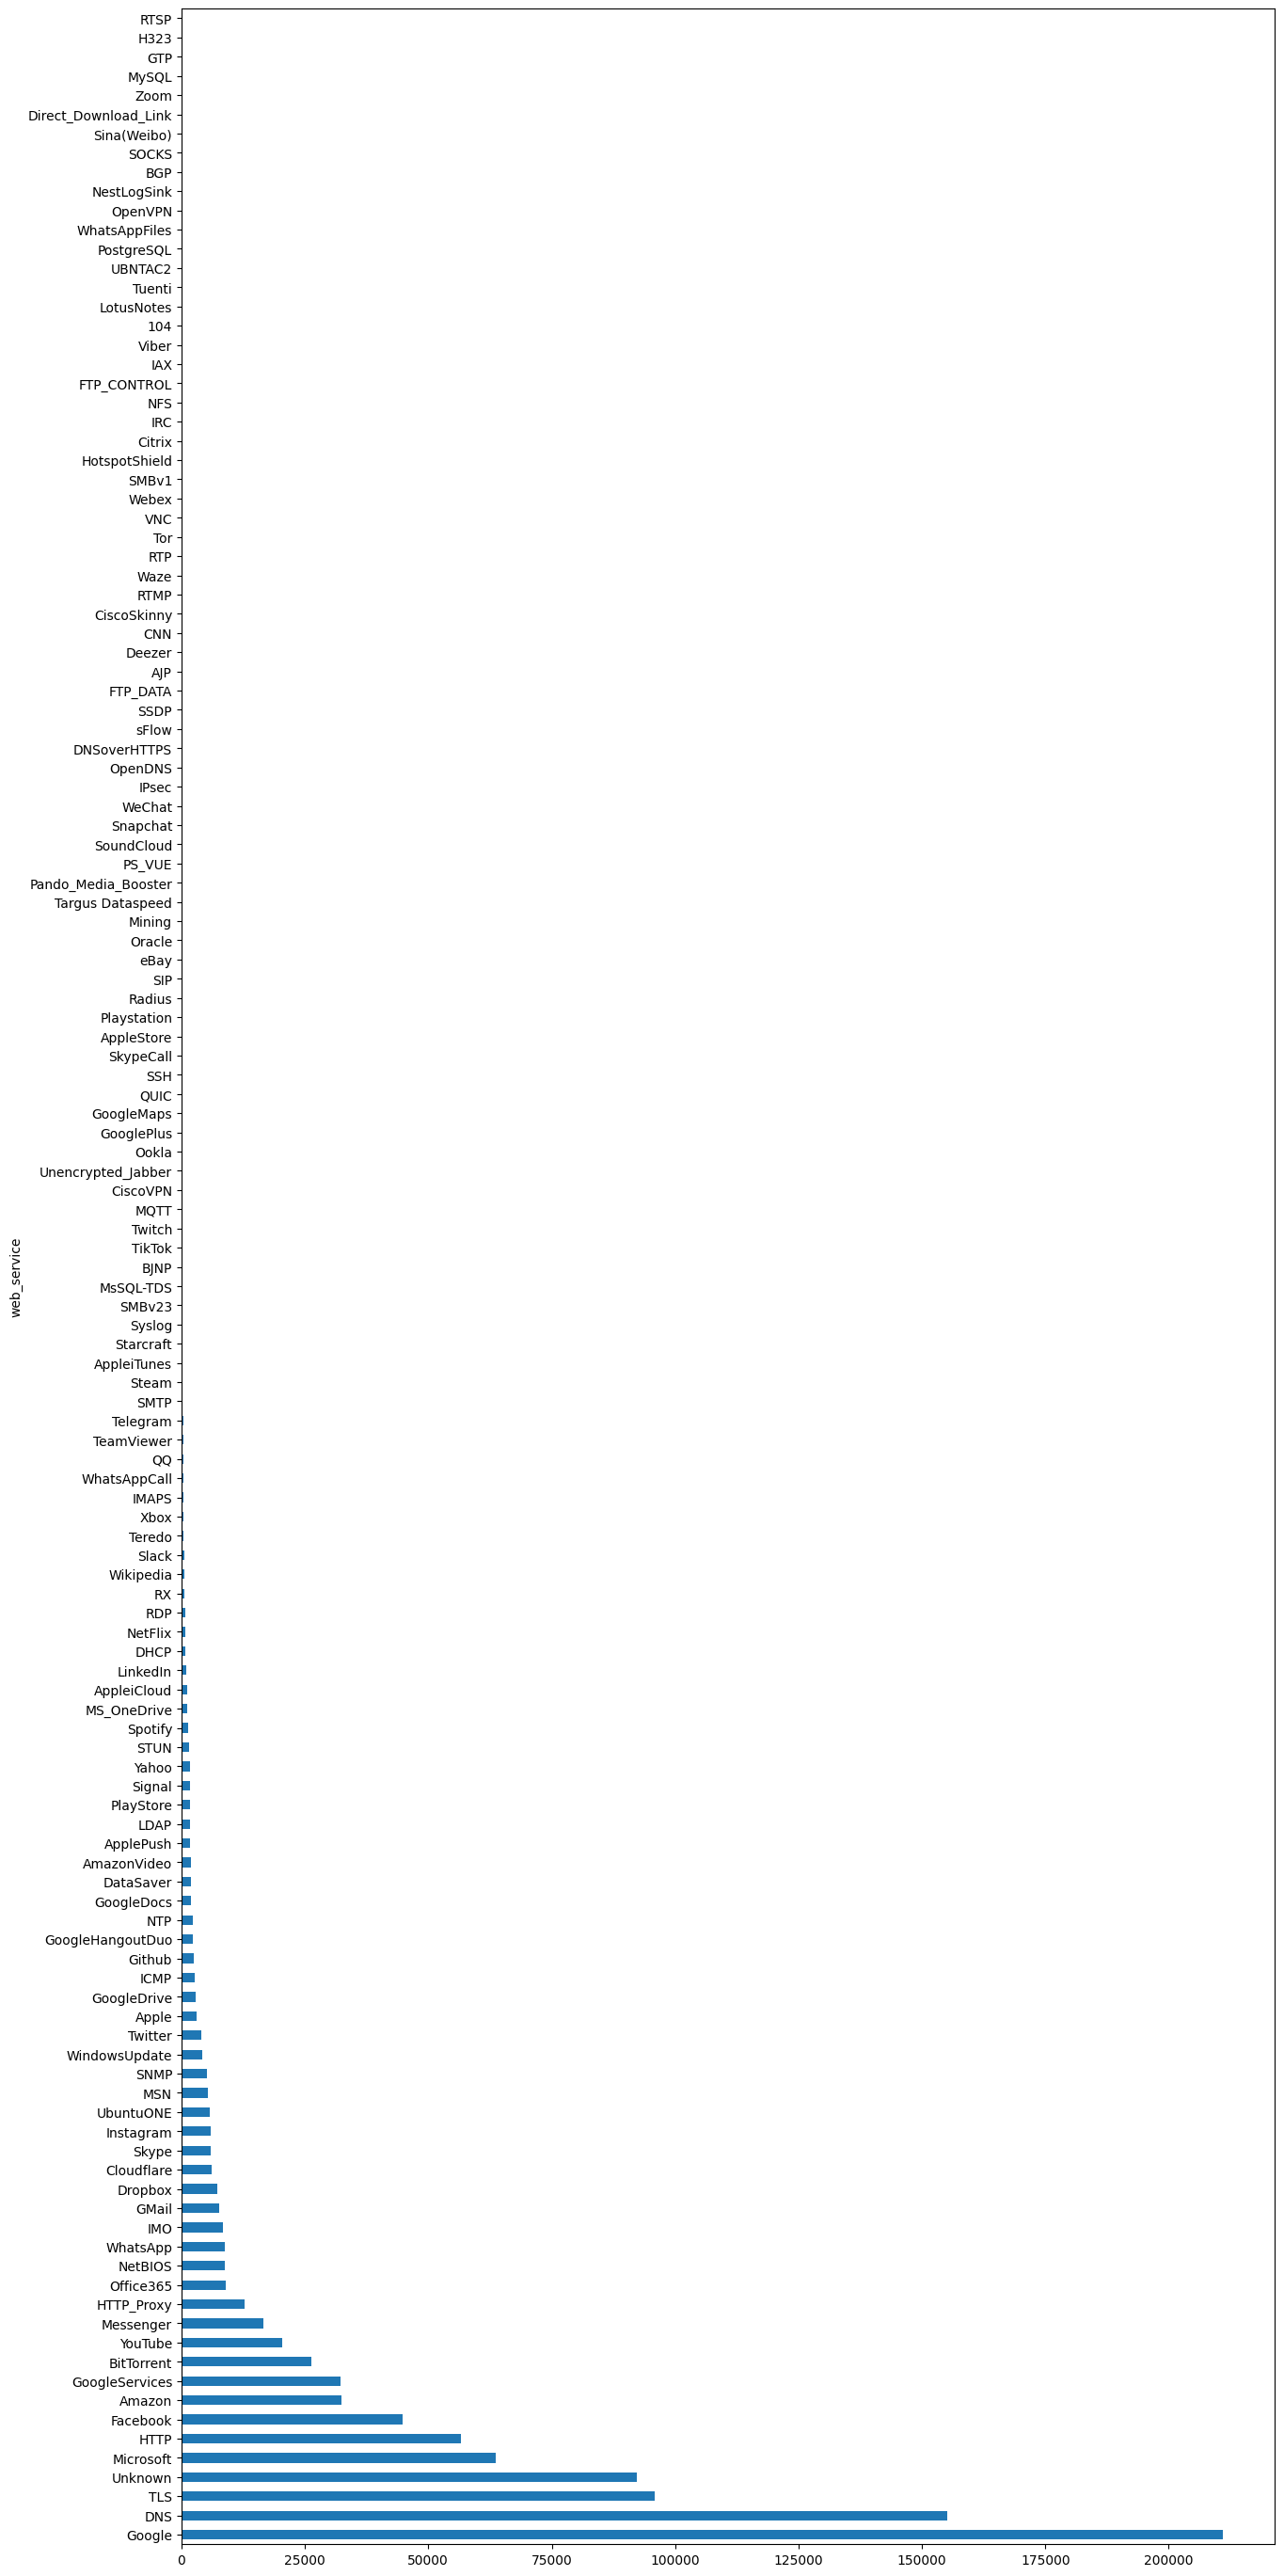

In [7]:
# DATA ANALYSIS
# Class distribution
print(net_apps_df['web_service'].value_counts())
net_apps_df['web_service'].value_counts().plot(kind='barh', figsize = (15, 35))

In [8]:
# Missing Values Null
net_apps_df.isnull().values.any()

False

In [9]:
# Identify duplicates
dups = net_apps_df[net_apps_df.duplicated()]
dups
len(dups)

1701

In [10]:
#Calculate Mean
net_apps_df_feats.mean(axis=0)

src_port             5.115343e+04
dst_port             2.727916e+03
proto                1.081501e+01
pktTotalCount        8.969357e+01
octetTotalCount      1.096616e+05
min_ps               5.822166e+01
max_ps               1.245379e+03
avg_ps               2.278735e+02
std_dev_ps           2.738634e+02
flowStart            1.557242e+09
flowEnd              1.557242e+09
flowDuration         5.367763e+01
min_piat             1.792229e+00
max_piat             2.336517e+01
avg_piat             4.790056e+00
std_dev_piat         5.897762e+00
f_pktTotalCount      3.737022e+01
f_octetTotalCount    1.803309e+04
f_min_ps             6.015875e+01
f_max_ps             4.110546e+02
f_avg_ps             1.340887e+02
f_std_dev_ps         1.075969e+02
f_flowStart          1.557242e+09
f_flowEnd            8.471221e+11
f_flowDuration       5.119562e+01
f_min_piat           3.652838e+00
f_max_piat           2.213497e+01
f_avg_piat           7.086194e+00
f_std_dev_piat       5.807974e+00
b_pktTotalCoun

In [11]:
#Calculate Variance Coefficient
for i in net_apps_df_feats.columns:
    col = net_apps_df_feats[i]
    cv = np.std(col) / np.mean(col) * 100
    print(f'{i} : {cv}')

src_port : 25.752177064057257
dst_port : 336.89161304615925
proto : 50.646823223821514
pktTotalCount : 3834.7938852678026
octetTotalCount : 4633.701577946583
min_ps : 102.73358564563534
max_ps : 235.1796375110053
avg_ps : 149.03130317927975
std_dev_ps : 194.53154808774343
flowStart : 0.10342384992895325
flowEnd : 0.10342381674909105
flowDuration : 339.23597569484696
min_piat : 1806.4416089306558
max_piat : 373.92054812854656
avg_piat : 803.4518740601234
std_dev_piat : 473.75184884045393
f_pktTotalCount : 3753.7675907969815
f_octetTotalCount : 13880.570871854303
f_min_ps : 111.74227911178396
f_max_ps : 185.8286714416079
f_avg_ps : 151.08329543566933
f_std_dev_ps : 203.41247224497582
f_flowStart : 0.10342384992895325
f_flowEnd : 91.47508263128336
f_flowDuration : 350.47081113155224
f_min_piat : 1326.9075670892569
f_max_piat : 387.00110269405616
f_avg_piat : 734.9993260820467
f_std_dev_piat : 419.43806746678456
b_pktTotalCount : 4275.479846795224
b_octetTotalCount : 4768.556842952159
b_mi

In [12]:
#Calculate Range
net_apps_df_feats.max() - net_apps_df_feats.min()

src_port             6.553500e+04
dst_port             6.553500e+04
proto                1.600000e+01
pktTotalCount        1.211846e+06
octetTotalCount      1.894699e+09
min_ps               5.804000e+03
max_ps               2.629200e+04
avg_ps               8.530237e+03
std_dev_ps           9.246916e+03
flowStart            3.817819e+06
flowEnd              3.817819e+06
flowDuration         1.800125e+03
min_piat             1.687423e+03
max_piat             1.763991e+03
avg_piat             1.687423e+03
std_dev_piat         8.604415e+02
f_pktTotalCount      5.135100e+05
f_octetTotalCount    1.885465e+09
f_min_ps             5.804000e+03
f_max_ps             2.629200e+04
f_avg_ps             8.895367e+03
f_std_dev_ps         7.908107e+03
f_flowStart          3.817819e+06
f_flowEnd            1.558215e+12
f_flowDuration       1.800125e+03
f_min_piat           1.729684e+03
f_max_piat           1.763991e+03
f_avg_piat           1.729684e+03
f_std_dev_piat       8.513964e+02
b_pktTotalCoun

In [13]:
#Calculate Interquatile Range
for i in net_apps_df_feats.columns:
    col = net_apps_df_feats[i]
    iqr = col.quantile(0.75) - col.quantile(0.25)
    print(f'{i} : {iqr}')

src_port : 9242.0
dst_port : 390.0
proto : 11.0
pktTotalCount : 16.0
octetTotalCount : 5160.0
min_ps : 25.0
max_ps : 1376.0
avg_ps : 179.7
std_dev_ps : 418.28690837037
flowStart : 3603740.856329918
flowEnd : 3603753.6544425488
flowDuration : 11.122435390949216
min_piat : 0.0007398128509521001
max_piat : 9.00003868341446
avg_piat : 1.0067143993718302
std_dev_piat : 1.6379431212592874
f_pktTotalCount : 8.0
f_octetTotalCount : 1474.0
f_min_ps : 25.0
f_max_ps : 496.0
f_avg_ps : 71.82416879795426
f_std_dev_ps : 159.41952248790923
f_flowStart : 3603740.856329918
f_flowEnd : 1554745779986.7136
f_flowDuration : 9.48749297857285
f_min_piat : 0.0003259181976318
f_max_piat : 6.875941574573518
f_avg_piat : 1.5729898129190725
f_std_dev_piat : 1.50121405720711
b_pktTotalCount : 8.0
b_octetTotalCount : 2742.0
b_min_ps : 52.0
b_max_ps : 1326.0
b_avg_ps : 233.66666666666703
b_std_dev_ps : 390.46123342602226
b_flowStart : 628429.9031627178
b_flowEnd : 628448.3501577377
b_flowDuration : 1554586280348.255

In [14]:
#Calculate Skew
for i in net_apps_df_feats.columns:
    col = net_apps_df_feats[i]
    skew = col.skew()
    print(f'{i} : {skew}')

src_port : -2.3167003479815182
dst_port : 4.728309121338999
proto : 0.23686892124566616
pktTotalCount : 165.0066199870596
octetTotalCount : 176.9129584245418
min_ps : 19.96938313147961
max_ps : 5.265222201067075
avg_ps : 4.592296507917178
std_dev_ps : 4.59946711749895
flowStart : 0.8381963533247436
flowEnd : 0.8381963291518599
flowDuration : 6.045955752772882
min_piat : 25.090944425472003
max_piat : 8.424483643461814
avg_piat : 17.53002843613857
std_dev_piat : 12.653368719389237
f_pktTotalCount : 160.52113041197774
f_octetTotalCount : 489.83874405632304
f_min_ps : 17.726108279600627
f_max_ps : 10.88714604916171
f_avg_ps : 8.408975935896775
f_std_dev_ps : 7.016276625158917
f_flowStart : 0.8381963533247436
f_flowEnd : -0.17474436214143824
f_flowDuration : 6.217952215267666
f_min_piat : 19.051758174756053
f_max_piat : 8.745741493101667
f_avg_piat : 16.158034476711936
f_std_dev_piat : 12.141946290479973
b_pktTotalCount : 210.848528323783
b_octetTotalCount : 180.44655455666168
b_min_ps : 35

In [ ]:
##################################################################
##################################################################
##################################################################
##################################################################

In [17]:
#Identify Anomalies / Noise
noise_analysis_df = net_apps_df_feats.sample(10000)
for i in noise_analysis_df.columns:
    print(i)
    col = noise_analysis_df[i]
    clustering = DBSCAN(eps=3, min_samples=2).fit(np.array(col).reshape(-1,1))
    print(f'{i}: {list(clustering.labels_).count(-1)}')

src_port
src_port: 1347
dst_port
dst_port: 493
proto
proto: 0
pktTotalCount
pktTotalCount: 118
octetTotalCount
octetTotalCount: 1383
min_ps
min_ps: 16
max_ps
max_ps: 237
avg_ps
avg_ps: 102
std_dev_ps
std_dev_ps: 173
flowStart
flowStart: 4076
flowEnd
flowEnd: 4021
flowDuration
flowDuration: 84
min_piat
min_piat: 17
max_piat
max_piat: 52
avg_piat
avg_piat: 28
std_dev_piat
std_dev_piat: 18
f_pktTotalCount
f_pktTotalCount: 76
f_octetTotalCount
f_octetTotalCount: 607
f_min_ps
f_min_ps: 17
f_max_ps
f_max_ps: 84
f_avg_ps
f_avg_ps: 55
f_std_dev_ps
f_std_dev_ps: 60
f_flowStart
f_flowStart: 4076
f_flowEnd
f_flowEnd: 8356
f_flowDuration
f_flowDuration: 84
f_min_piat
f_min_piat: 35
f_max_piat
f_max_piat: 56
f_avg_piat
f_avg_piat: 32
f_std_dev_piat
f_std_dev_piat: 23
b_pktTotalCount
b_pktTotalCount: 81
b_octetTotalCount
b_octetTotalCount: 1123
b_min_ps
b_min_ps: 11
b_max_ps
b_max_ps: 233
b_avg_ps
b_avg_ps: 164
b_std_dev_ps
b_std_dev_ps: 191
b_flowStart
b_flowStart: 3980
b_flowEnd
b_flowEnd: 3926
b_

<Axes: >

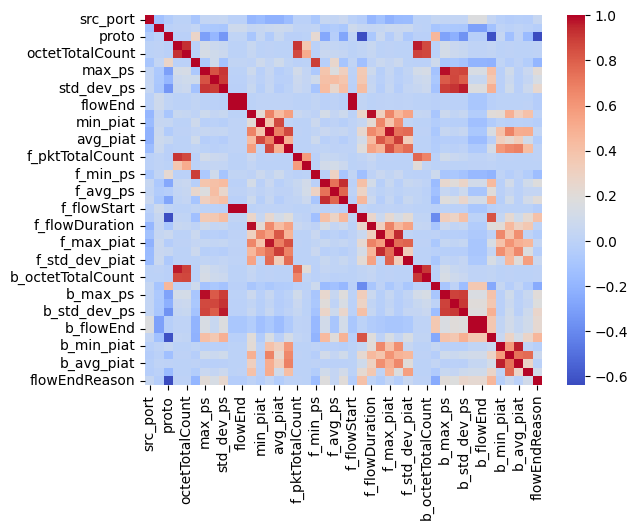

In [18]:
# Corelation analysis
corr_ana = net_apps_df_feats.corr()
sns.heatmap(corr_ana, cmap='coolwarm')

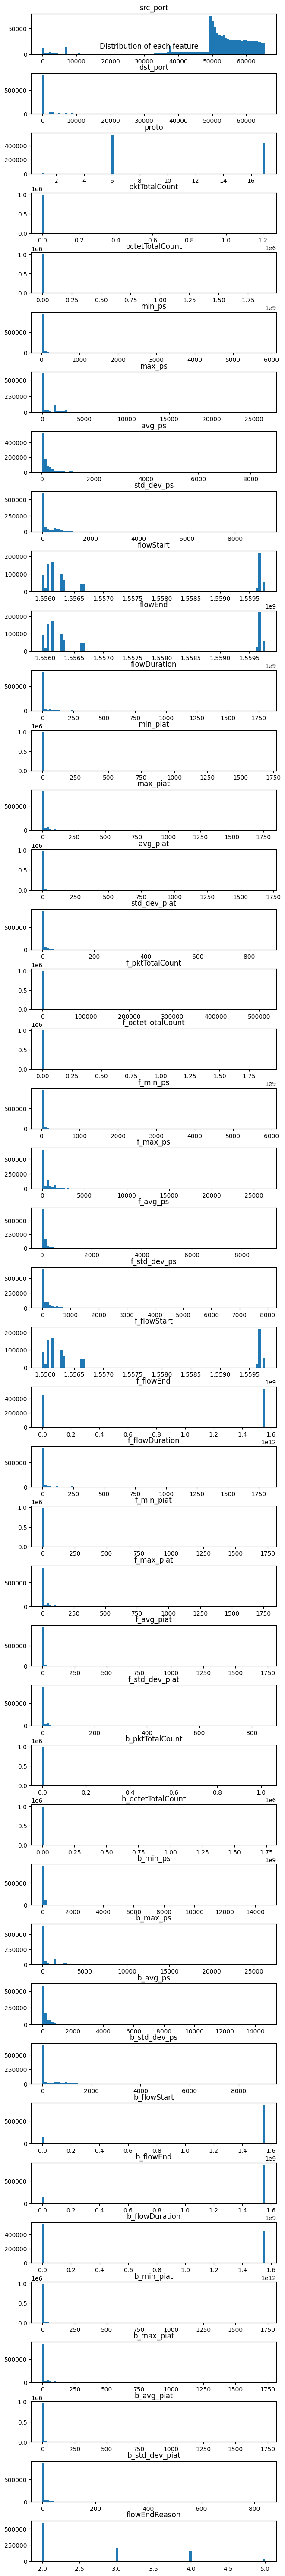

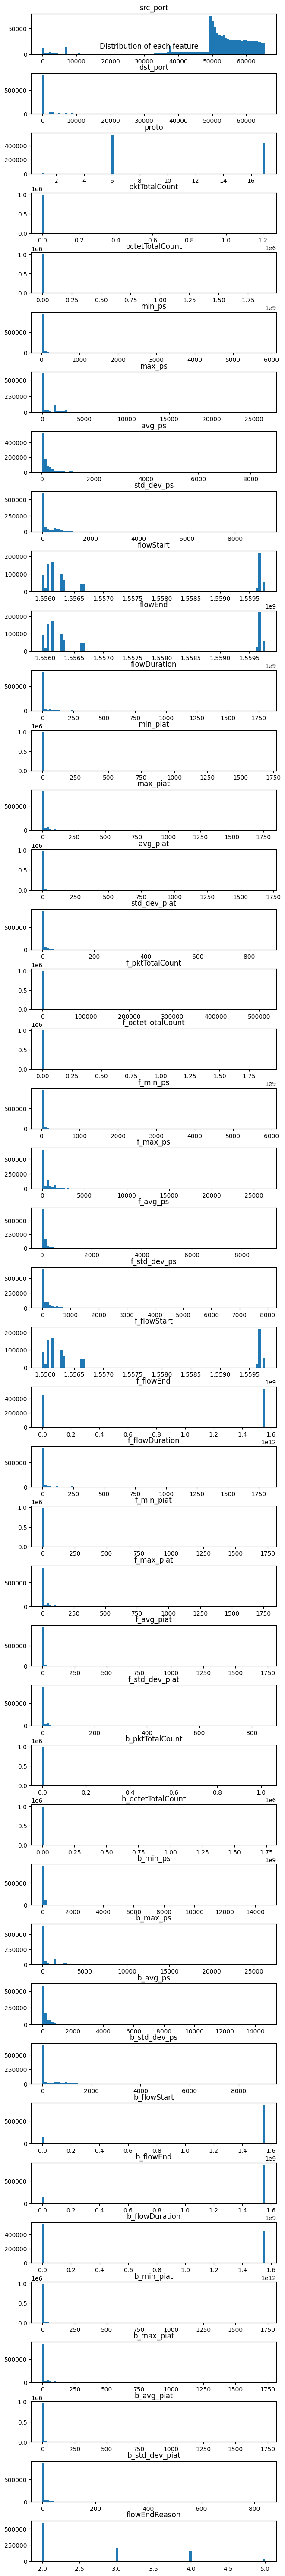

In [19]:
# Plot distribution for each feature

fig, axs = plt.subplots(len(list(net_apps_df_feats.columns.values)))
fig.suptitle('Distribution of each feature')
fig.set_figheight(60)
fig.tight_layout()

plt_number = 0
for feature in net_apps_df_feats.columns.values:
    axs[plt_number].hist(net_apps_df_feats[feature],bins=100)
    axs[plt_number].set_title(feature)
    plt_number += 1
    
    
fig

In [22]:
# Feature Importance
sel = SelectFromModel(RandomForestClassifier(verbose=3))
sel.fit(X_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:  5.9min


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

SelectFromModel(estimator=RandomForestClassifier(verbose=3))

In [23]:
sel.get_support()
selected_feat= X_train.columns[(sel.get_support())]
print(f'Total Important Features: {len(selected_feat)}')
print(selected_feat)

Total Important Features: 18
Index(['src_port', 'dst_port', 'octetTotalCount', 'min_ps', 'max_ps', 'avg_ps',
       'std_dev_ps', 'flowDuration', 'min_piat', 'max_piat',
       'f_octetTotalCount', 'f_min_ps', 'f_max_ps', 'f_avg_ps',
       'b_octetTotalCount', 'b_min_ps', 'b_max_ps', 'b_avg_ps'],
      dtype='object')


In [7]:
# Implement without feature selection
forest = RandomForestClassifier(verbose=3)
forest.fit(X_train, y_train)

y_pred_test = forest.predict(X_test)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:  2.8min


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    4.0s


In [8]:
# Without feature selection analysis
print(f'Overall accuracy: {accuracy_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

Overall accuracy: 0.83774
                      precision    recall  f1-score   support

                 104       0.00      0.00      0.00         2
                 AJP       0.00      0.00      0.00         3
              Amazon       0.71      0.46      0.56      4887
         AmazonVideo       0.87      0.60      0.71       291
               Apple       0.77      0.42      0.54       465
           ApplePush       0.93      0.89      0.91       274
          AppleStore       0.40      0.10      0.16        20
         AppleiCloud       0.93      0.68      0.79       151
         AppleiTunes       0.82      0.21      0.34        42
                BJNP       0.95      1.00      0.98        21
          BitTorrent       0.99      0.98      0.98      3833
                 CNN       0.00      0.00      0.00         0
         CiscoSkinny       1.00      0.67      0.80         3
            CiscoVPN       0.83      0.86      0.84        22
              Citrix       0.00      0.00  

In [10]:
# Implement with feature selection
forest_fs = RandomForestClassifier(verbose=3)
selected_feat = ['src_port', 'dst_port', 'octetTotalCount', 'min_ps', 'max_ps', 'avg_ps',
       'std_dev_ps', 'flowDuration', 'min_piat', 'max_piat',
       'f_octetTotalCount', 'f_min_ps', 'f_max_ps', 'f_avg_ps',
       'b_octetTotalCount', 'b_min_ps', 'b_max_ps', 'b_avg_ps']
lim_features = net_apps_df[selected_feat]
lim_feat_target = net_apps_df['web_service']
X_train_fs,X_test_fs,y_train_fs,y_test_fs = train_test_split(lim_features, lim_feat_target,test_size=0.3)

In [11]:
forest_fs.fit(X_train_fs, y_train_fs)
y_pred_test_fs = forest_fs.predict(X_test_fs)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:  1.8min


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    5.2s


In [12]:
# With feature selection analysis
print(f'Overall accuracy: {accuracy_score(y_test_fs, y_pred_test_fs)}')
print(classification_report(y_test_fs, y_pred_test_fs))

Overall accuracy: 0.8298133333333333
                     precision    recall  f1-score   support

                104       0.00      0.00      0.00         1
             Amazon       0.64      0.47      0.54      4871
        AmazonVideo       0.79      0.61      0.69       283
              Apple       0.64      0.47      0.54       414
          ApplePush       0.95      0.91      0.93       281
         AppleStore       0.75      0.35      0.48        17
        AppleiCloud       0.89      0.72      0.80       166
        AppleiTunes       0.75      0.31      0.44        39
               BJNP       1.00      1.00      1.00        23
         BitTorrent       0.99      0.99      0.99      3963
                CNN       0.00      0.00      0.00         2
        CiscoSkinny       1.00      0.50      0.67         2
           CiscoVPN       0.93      0.72      0.81        18
         Cloudflare       0.70      0.30      0.42      1002
               DHCP       1.00      1.00      1